In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import tensorflow as tf


In [2]:
# Create directory for saving models if it doesn't exist
model_dir = '../notebook/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [3]:
# Load the datasets
creditcard_data = pd.read_csv('../data/creditcard.csv')
creditcard_data .head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
fraud_data = pd.read_csv('../data/Fraud_cleaned_data.csv')
fraud_data.head()

,purchase_value,age,ip_address,class,frequency,velocity,hour_of_day,day_of_week,time_diff,signup_hour,signup_day_of_week,purchase_day_of_week,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,0.172414,0.362069,0.170603,0,1,34,0.086957,0.833333,4506682.0,22,1,5,False,True,False,False,False,False,True
1,0.048276,0.603448,0.081554,0,1,16,0.043478,0.000000,17944.0,20,6,0,False,False,False,False,False,False,False
2,0.041379,0.603448,0.610371,1,1,15,0.782609,0.500000,1.0,18,3,3,False,True,False,False,True,False,True
3,0.241379,0.396552,0.894219,0,1,44,0.565217,0.000000,492085.0,21,1,0,False,True,False,False,False,True,True
4,0.206897,0.465517,0.096752,0,1,39,0.782609,0.333333,4361461.0,7,1,2,False,False,False,False,False,True,True


In [5]:
# Data Preprocessing for Credit Card Data
X_creditcard = creditcard_data.drop(columns=['Class'])  # Features
y_creditcard = creditcard_data['Class']                 # Target

# Data Preprocessing for Fraud Data
X_fraud = fraud_data.drop(columns=['class'])  # Features
y_fraud = fraud_data['class']                 # Target

# Scaling the data (Min-Max Scaling)
scaler = MinMaxScaler()
X_creditcard_scaled = scaler.fit_transform(X_creditcard)
X_fraud_scaled = scaler.fit_transform(X_fraud)



In [6]:
# Train-test split for both datasets
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = train_test_split(
    X_creditcard_scaled, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud_scaled, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

In [7]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_creditcard_resampled, y_train_creditcard_resampled = smote.fit_resample(X_train_creditcard, y_train_creditcard)
X_train_fraud_resampled, y_train_fraud_resampled = smote.fit_resample(X_train_fraud, y_train_fraud)


In [8]:
import numpy as np 
# Reshape the input data to 3D for RNN (samples, timesteps, features)
X_train_creditcard_resampled = np.expand_dims(X_train_creditcard_resampled, axis=1)
X_test_creditcard = np.expand_dims(X_test_creditcard, axis=1)

X_train_fraud_resampled = np.expand_dims(X_train_fraud_resampled, axis=1)
X_test_fraud = np.expand_dims(X_test_fraud, axis=1)

# Convert the target variables to categorical (one-hot encoding)
y_train_creditcard_resampled = to_categorical(y_train_creditcard_resampled)
y_test_creditcard = to_categorical(y_test_creditcard)

y_train_fraud_resampled = to_categorical(y_train_fraud_resampled)
y_test_fraud = to_categorical(y_test_fraud)

In [9]:
# Define a simple RNN model
def build_rnn(input_shape, output_units):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_units, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# Build and train RNN for Credit Card Data
rnn_creditcard = build_rnn((1, X_train_creditcard_resampled.shape[2]), 2)
history_creditcard = rnn_creditcard.fit(X_train_creditcard_resampled, y_train_creditcard_resampled,
                                        epochs=10, validation_split=0.2, batch_size=32)



c:\Users\getac\anaconda3\envs\myenve\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9370 - loss: 0.1682 - val_accuracy: 0.9370 - val_loss: 0.1326
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9599 - loss: 0.1023 - val_accuracy: 0.9687 - val_loss: 0.0746
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9695 - loss: 0.0767 - val_accuracy: 0.9270 - val_loss: 0.1744
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9763 - loss: 0.0610 - val_accuracy: 0.9884 - val_loss: 0.0354
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9791 - loss: 0.0538 - val_accuracy: 0.9818 - val_loss: 0.0444
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9820 - loss: 0.0467 - val_accuracy: 0.9791 - val_loss: 0.0481
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9841 - loss: 0.0419 - val_accuracy: 0.9870 - val_loss: 0.0364
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 

In [11]:
# Build and train RNN for Fraud Data
rnn_fraud = build_rnn((1, X_train_fraud_resampled.shape[2]), 2)
history_fraud = rnn_fraud.fit(X_train_fraud_resampled, y_train_fraud_resampled,
                              epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7875 - loss: 0.4937 - val_accuracy: 0.5600 - val_loss: 0.6536
Epoch 2/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8283 - loss: 0.4226 - val_accuracy: 0.5554 - val_loss: 0.6478
Epoch 3/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8286 - loss: 0.4179 - val_accuracy: 0.5550 - val_loss: 0.6846
Epoch 4/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8286 - loss: 0.4139 - val_accuracy: 0.5539 - val_loss: 0.7028
Epoch 5/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8287 - loss: 0.4137 - val_accuracy: 0.5547 - val_loss: 0.6852
Epoch 6/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8298 - loss: 0.4092 - val_accuracy: 0.5560 - val_loss: 0.7288
Epoch 7/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8312 - loss: 0.4061 - val_accuracy: 0.5589 - val_loss: 0.7036
Epoch 8/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8328 - loss: 0

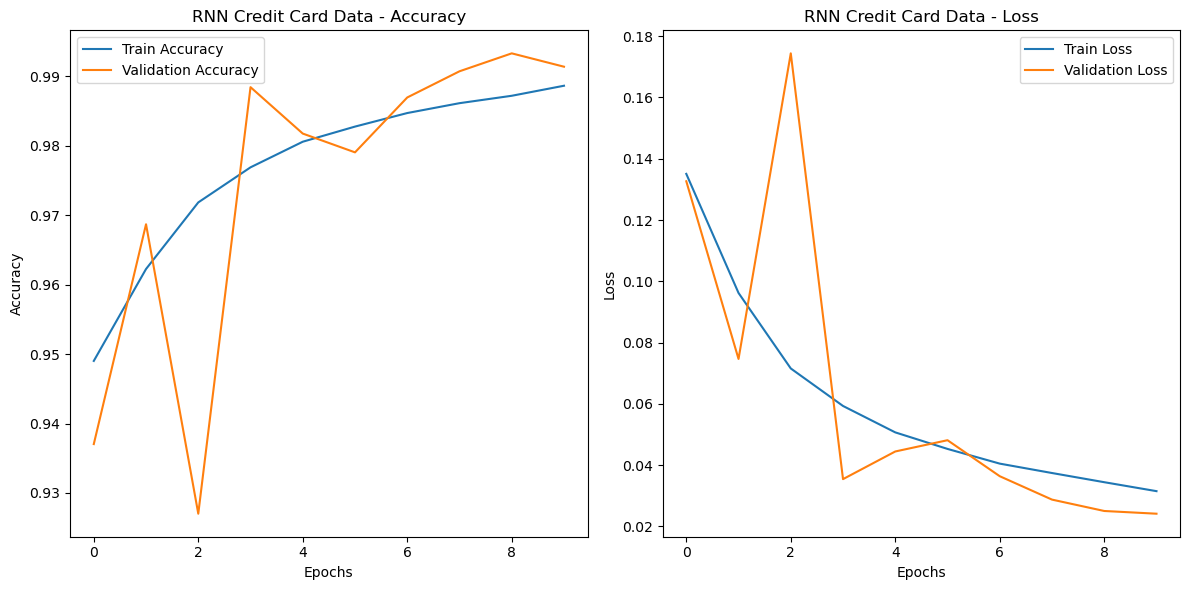

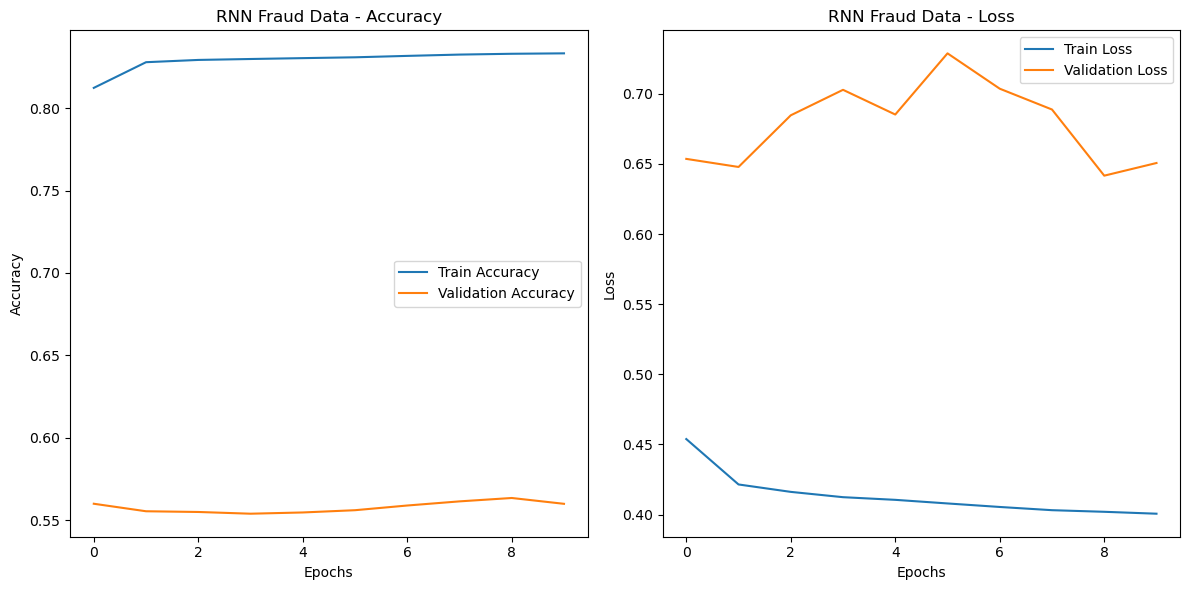

In [12]:
# Plot training vs. validation accuracy/loss
def plot_training_history(history, title):
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for Credit Card Data
plot_training_history(history_creditcard, 'RNN Credit Card Data')

# Plot for Fraud Data
plot_training_history(history_fraud, 'RNN Fraud Data')

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [14]:
from sklearn.metrics import precision_recall_fscore_support

# Function to calculate and print the accuracy, precision, recall, and F1 score
def evaluate_and_print_metrics(model, X_test, y_test, dataset_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Print classification report
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true_classes, y_pred_classes, dataset_name)
    
    # Return the metrics for comparison plotting
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Credit Card Data Metrics:
Accuracy: 0.9837
Weighted Precision: 0.9982
Weighted Recall: 0.9837
Weighted F1 Score: 0.9903

Classification Report for Credit Card Data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.88      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.57     56962
weighted avg       1.00      0.98      0.99     56962



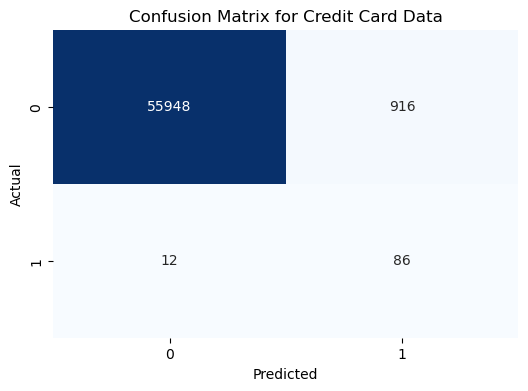

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Fraud Data Metrics:
Accuracy: 0.9519
Weighted Precision: 0.9507
Weighted Recall: 0.9519
Weighted F1 Score: 0.9459

Classification Report for Fraud Data:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.92      0.53      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.94      0.76      0.82     30223
weighted avg       0.95      0.95      0.95     30223



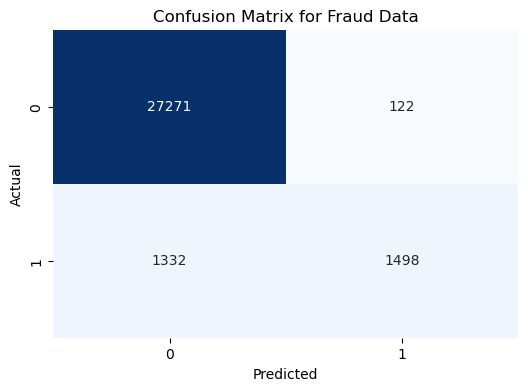

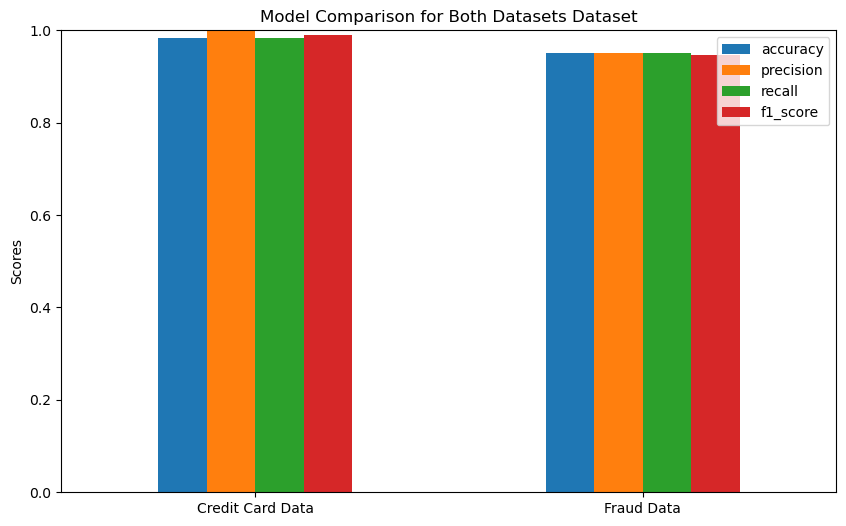

In [15]:
# Function to plot model comparison based on metrics
def plot_model_comparison(metrics_dict, dataset_name):
    metrics_df = pd.DataFrame(metrics_dict).T  # Transpose for easier plotting
    metrics_df.plot(kind='bar', figsize=(10, 6))
    
    plt.title(f'Model Comparison for {dataset_name} Dataset')
    plt.ylabel('Scores')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1 for better comparison
    plt.legend(loc='upper right')
    plt.show()

# Evaluate and collect metrics for both datasets
creditcard_metrics = evaluate_and_print_metrics(rnn_creditcard, X_test_creditcard, y_test_creditcard, "Credit Card Data")
fraud_metrics = evaluate_and_print_metrics(rnn_fraud, X_test_fraud, y_test_fraud, "Fraud Data")

# Combine the metrics into a dictionary for comparison
model_comparison_metrics = {
    'Credit Card Data': creditcard_metrics,
    'Fraud Data': fraud_metrics
}

# Plot the comparison of accuracy, precision, recall, and F1 score for both datasets
plot_model_comparison(model_comparison_metrics, "Both Datasets")

In [16]:
import os

# Create the directory to save the models if it doesn't exist
model_dir = '../notebooks/model/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the RNN models after training
rnn_creditcard.save(os.path.join(model_dir, 'rnn_creditcard.h5'))
rnn_fraud.save(os.path.join(model_dir, 'rnn_fraud.h5'))

print("Models saved successfully!")

Models saved successfully!
